<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

1) Cross-matching the xCOLDGASS sample with the xGASS galaxies to investigate the molecular hydrogen, H2 in the galaxy. This is in the optical region of a galaxy and therefore will not require the process used for HI.

In [34]:
# Reading in the cross-matched .fits file:
hdulist = fits.open('xGASSCOLDGASS_matched.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
GASS_0 = hdu['GASS']
FLAG_CO_0 = hdu['FLAG_CO']
LumCO_corr_0 = hdu['LCO_COR']
lgMH2_0 = hdu['LOGMH2']
limlgMH2_0 = hdu['LIM_LOGMH2']
lgMH2_2_Ms_0 = hdu['LOGMH2MS']
lgMSTAR_0 = hdu['LOGMSTAR']
lgSFRbest_0 = hdu['LOGSFR_BEST']
NUVr_0 = hdu['NUVr_2']
lgMuST_0 = hdu['LOGMUST']
lgsSFR_0 = np.log10((10**lgSFRbest_0) / (10**lgMSTAR_0))
print('Starting length of the dataset is', len(FLAG_CO_0))

Starting length of the dataset is 477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [ ]:
# Checking whether any of the galaxies in the dataset are missing important values
print('Data without H2 mass values:', np.where((lgMH2_0 < 0) & (limlgMH2_0 < 0))[0], np.where(np.isnan(lgMH2_0))[0], np.where(np.isnan(lgMH2_0))[0])
print('Data without stellar mass values:', np.where(lgMSTAR_0 < 0)[0], np.where(np.isnan(lgMSTAR_0))[0])
print('Data without SFR values:', np.where(lgSFRbest_0 < -9999)[0], np.where(np.isnan(lgSFRbest_0))[0])
print('Data without NUV-r values:', np.where(NUVr_0 < 0)[0], np.where(np.isnan(NUVr_0))[0])
print('Data without stellar mass density values:', np.where(lgMuST_0 < 0)[0], np.where(np.isnan(lgMuST_0))[0])

Data without H2 mass values: [] [] []
Data without stellar mass values: [] []
Data without SFR values: [ 77 256] [ 60 381]
Data without NUV-r values: [] [127 128 159 197 219 263 416]
Data without stellar mass density values: [] [197 332]


In [35]:
# Removing from the original dataset the values that fail the checks above:
GASS = np.delete(GASS_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
FLAG_CO = np.delete(FLAG_CO_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
LumCO_corr = np.delete(LumCO_corr_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgMH2 = np.delete(lgMH2_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
limlgMH2 = np.delete(limlgMH2_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgMH2_2_Ms = np.delete(lgMH2_2_Ms_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgMSTAR = np.delete(lgMSTAR_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgSFRbest = np.delete(lgSFRbest_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
NUVr = np.delete(NUVr_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgMuST = np.delete(lgMuST_0, (60, 77, 127, 128, 159, 197, 219, 256, 263, 332, 381, 416))
lgsSFR = np.log10((10**lgSFRbest) / (10**lgMSTAR))
print('The number of galaxies in the dataset is now:', len(FLAG_CO))

The number of galaxies in the dataset is now: 465


In [ ]:
# Need to separate the H2 data into the detections and the non-detection upper limits
# We can use the CO flag for this, 1 = H2 detection, 2 = no H2 detection (upper limit only)
# H2 detections
lgMH2_det = np.delete(lgMH2, (np.where(FLAG_CO > 1)))
lgMSTAR_det = np.delete(lgMSTAR, (np.where(FLAG_CO > 1)))
lgSFRbest_det = np.delete(lgSFRbest, (np.where(FLAG_CO > 1)))
NUVr_det = np.delete(NUVr, (np.where(FLAG_CO > 1)))
lgMuST_det = np.delete(lgMuST, (np.where(FLAG_CO > 1)))
lgsSFR_det = np.delete(lgsSFR, (np.where(FLAG_CO > 1)))
# H2 non-detections
limlgMH2_ndet = np.delete(limlgMH2, (np.where(FLAG_CO < 2)))
lgMSTAR_ndet = np.delete(lgMSTAR, (np.where(FLAG_CO < 2)))
lgSFRbest_ndet = np.delete(lgSFRbest, (np.where(FLAG_CO < 2)))
NUVr_ndet = np.delete(NUVr, (np.where(FLAG_CO < 2)))
lgMuST_ndet = np.delete(lgMuST, (np.where(FLAG_CO < 2)))
lgsSFR_ndet = np.delete(lgsSFR, (np.where(FLAG_CO < 2)))

2) Plotting how the H2 changes with stellar mass and SFR

In [ ]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
H2bins = np.linspace(9, 11.9, 10)
H2bins2 = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
mH2_1 = np.zeros(len(H2bins))
H2median1 = np.zeros(len(H2bins))
H2MAD1 = np.zeros(len(H2bins))

mH2_2 = np.zeros(len(H2bins2))
H2median2 = np.zeros(len(H2bins2))
H2MAD2 = np.zeros(len(H2bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins) -1):
  # Median and MAD for H2 of galaxies against stellar mass
  H2median1[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  H2MAD1[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  mH2_1[i] = H2median1[i]

for i in range (len(H2bins2) -1):
  # Median and MAD for H2 of galaxies against SFR
  H2median2[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  H2MAD2[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  mH2_2[i] = H2median2[i]

# Working out the upper and lower bounds of the median absolute deviation
H2pMAD1 = mH2_1 + H2MAD1
H2nMAD1 = mH2_1 - H2MAD1
H2pMAD2 = mH2_2 + H2MAD2
H2nMAD2 = mH2_2 - H2MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


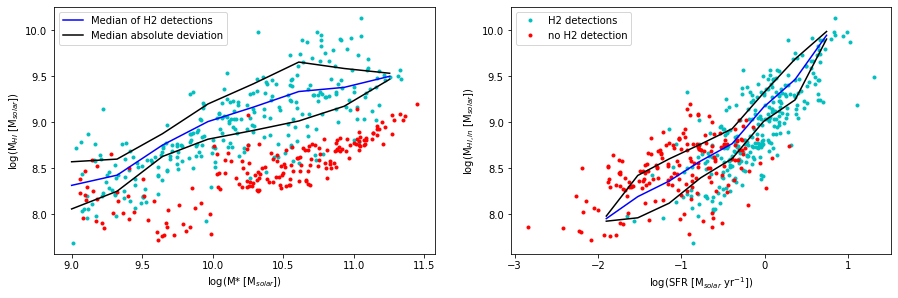

In [ ]:
# Plotting the relations between the H2 mass in the galaxy and stellar mass as well as the Star formation rate
plt.figure(figsize = (15,10))
# H2 mass against Stellar mass
plt.subplot(221)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins[:-2], mH2_1[:-2], 'b-', label = 'Median of H2 detections')
plt.plot(H2bins[:-2], H2pMAD1[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(H2bins[:-2], H2nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left')

# H2 mass against Star formation rate
plt.subplot(222)
plt.plot(lgSFRbest_det, lgMH2_det, 'c.', label= 'H2 detections')
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'r.', label= 'no H2 detection')
plt.plot(H2bins2[:-2], mH2_2[:-2], 'b-')
plt.plot(H2bins2[:-2], H2pMAD2[:-2], 'k-')
plt.plot(H2bins2[:-2], H2nMAD2[:-2], 'k-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.legend(loc='upper left');

3) Comparing how the H2 mass changes with various stellar properties, plotted with how the global HI mass changes and how the HI mass inside the optical region changes

In [38]:
# Reading the HI masses dataset in, this will need to be cut so that only the 465 galaxies with the relevant quantities and appear in both xGASS and xCOLDGASS appear
GASSID_0, lgMHI_global_0, lgMHI_2Reff_0, lgMHI_r90, HIsource, r90kpc, Reffkpc = np.loadtxt('xGASS_HI_masses.txt',skiprows = 1, unpack=True)
# Matching the 912 galaxies from the cut xGASS sample with the ones that also appear in xCOLDGASS, using the GASS ID's
print(len(np.where(GASSID_0 == GASS)[0]))
print(GASS[0:11])
print(GASSID_0[0:11])

0
[124028 124012  11956  12025 124006 124000 124010  12002 124004  11989
  11994]
[ 11834.  11892.  11825. 124028. 124009. 124012.  11910.  11956.  12030.
  12025. 124006.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
